In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [37]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [73]:
cora_dataset = get_cora_dataset()

In [7]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [9]:
epochs = 200
dim = 16

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [11]:
num_classes, num_features

(4, 1)

In [12]:
cora_dataset.x.shape

torch.Size([2708, 1433])

In [13]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:1.006355 Train_acc: 0.6446, Test_acc: 0.8071]: 100%|████████████████████| 200/200 [00:01<00:00, 172.44it/s]


In [14]:
num_classes = len(set([int(i) for i in cora_dataset.y]))
num_features = cora_dataset.x.shape[-1]

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [16]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model)

[Train_loss:1.582272 Train_acc: 0.4204, Test_acc: 0.4340]: 100%|█████████████████████| 200/200 [00:03<00:00, 62.23it/s]


In [17]:
explainer = GNNExplainer(model, epochs=200)

In [18]:
node_feature_mask, edge_mask = explain_model(explainer,cora_dataset,10)

Explain node 10: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 603.63it/s]


In [19]:
gce_explainer = GCExplainer()

In [20]:
gce_explainer.learn_prototypes(model,cora_dataset)

In [21]:
gce_explainer.get_prediction(model,cora_dataset)

array([2, 0, 0, ..., 3, 2, 2], dtype=int64)

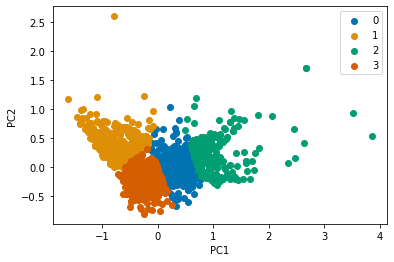

In [22]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [23]:
gce_explainer.get_prediction(model,identity(cora_dataset))

array([2, 0, 0, ..., 3, 2, 2], dtype=int64)

In [24]:
model = GCNNet_NC(num_features, num_classes, model_args)

In [25]:
cora_dataset.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [26]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model,protgnn=True)

[Train_loss:0.229882 Train_acc: 0.2922, Test_acc: 0.3280]: 100%|█████████████████████| 200/200 [00:39<00:00,  5.08it/s]


In [27]:
prot_explainer = ProtGNNExplainer()

In [28]:
prot_explainer.learn_prototypes(model,cora_dataset)

In [29]:
prot_explainer.get_prediction(model,cora_dataset)

array([22, 22, 22, ..., 22, 22, 22], dtype=int64)

In [30]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes).to(device)

In [31]:
# register hooks to track activation
model = register_hooks(model)

In [32]:
train_model(epochs,model,device,cora_dataset,optimizer,test_model,if_interpretable_model=True)

[Train_loss:0.096037 Train_acc: 0.0738, Test_acc: 0.0660]: 100%|█████████████████████| 200/200 [00:07<00:00, 27.16it/s]


GCN(
  (conv0): GCNConv(1433, 16)
  (conv1): GCNConv(16, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lens): Sequential(
    (0): EntropyLinear(
      in_features=16, out_features=1, n_classes=7
      (conceptizator): Conceptizator(activation=identity_bool, threshold=0.5)
    )
  )
)

In [33]:
cdm_explainer = CDMExplainer()

In [34]:
cdm_explainer.get_explanation(model, cora_dataset, activation_list)


2
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
feature0000000003
2
Explanation class 1: feature0000000003 - acc. = 0.0660 - compl. = 1.0000
feature0000000012
2
Explanation class 2: feature0000000012 - acc. = 0.1480 - compl. = 1.0000
feature0000000012
2
Explanation class 3: feature0000000012 - acc. = 0.3280 - compl. = 1.0000
feature0000000014
2
Explanation class 4: feature0000000014 - acc. = 0.2280 - compl. = 1.0000
~feature0000000001 & ~feature0000000012 & ~feature0000000014
2
Explanation class 5: ~feature0000000001 & ~feature0000000012 & ~feature0000000014 - acc. = 0.9220 - compl. = 3.0000
~feature0000000001 & ~feature0000000003 & ~feature0000000014
2
Explanation class 6: ~feature0000000001 & ~feature0000000003 & ~feature0000000014 - acc. = 0.9500 - compl. = 3.0000


{'0': {'explanation': '',
  'explanation_accuracy': 0.0,
  'explanation_complexity': 0},
 '1': {'explanation': 'feature0000000003',
  'explanation_accuracy': 0.066,
  'explanation_complexity': 1},
 '2': {'explanation': 'feature0000000012',
  'explanation_accuracy': 0.148,
  'explanation_complexity': 1},
 '3': {'explanation': 'feature0000000012',
  'explanation_accuracy': 0.328,
  'explanation_complexity': 1},
 '4': {'explanation': 'feature0000000014',
  'explanation_accuracy': 0.228,
  'explanation_complexity': 1},
 '5': {'explanation': '~feature0000000001 & ~feature0000000012 & ~feature0000000014',
  'explanation_accuracy': 0.922,
  'explanation_complexity': 3},
 '6': {'explanation': '~feature0000000001 & ~feature0000000003 & ~feature0000000014',
  'explanation_accuracy': 0.95,
  'explanation_complexity': 3}}

In [74]:
aggressive_adversary(cora_dataset, frac=0.1)

Data(x=[2708, 1433], edge_index=[2, 14104], y=[2708], train_mask=[2708], test_mask=[2708])